<a href="https://colab.research.google.com/github/Bast-94/ASL-PW/blob/main/TP_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [49]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self, latent_dim: int = 50,hidden_dim:int =400):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, hidden_dim)
        self.latent_dim = latent_dim
        self.fc21 = nn.Linear(hidden_dim, self.latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(hidden_dim, self.latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(self.latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
def train_vae(vae: VAE,optimizer, train_loader,n_epochs=10,loss_function =loss_function):

  for epoch in tqdm(range(n_epochs)):
      vae.train()
      train_loss = 0
      for data, _ in train_loader:
          data = data.to(device)
          optimizer.zero_grad()
          recon_batch, mu, logvar = vae(data)
          loss = loss_function(recon_batch, data, mu, logvar)
          loss.backward()
          train_loss += loss.item()
          optimizer.step()

      print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [2]:
vae(next(iter(train_loader))[0])[0].size()

torch.Size([128, 784])

## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

### Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_vae(vae,optimizer,train_loader=train_loader)

 10%|█         | 1/10 [00:17<02:35, 17.29s/it]

Epoch 0, Loss: 169.2148652669271


 20%|██        | 2/10 [00:34<02:15, 16.97s/it]

Epoch 1, Loss: 125.97935678710938


 30%|███       | 3/10 [00:50<01:58, 16.97s/it]

Epoch 2, Loss: 116.92253427734374


 40%|████      | 4/10 [01:08<01:42, 17.02s/it]

Epoch 3, Loss: 112.86197369791667


 50%|█████     | 5/10 [01:25<01:26, 17.27s/it]

Epoch 4, Loss: 110.43561331380208


 60%|██████    | 6/10 [01:43<01:09, 17.31s/it]

Epoch 5, Loss: 108.93940921223958


 70%|███████   | 7/10 [02:00<00:51, 17.22s/it]

Epoch 6, Loss: 107.82909293619791


 80%|████████  | 8/10 [02:17<00:34, 17.14s/it]

Epoch 7, Loss: 107.18618525390625


 90%|█████████ | 9/10 [02:35<00:17, 17.42s/it]

Epoch 8, Loss: 106.51663701171876


100%|██████████| 10/10 [02:52<00:00, 17.27s/it]

Epoch 9, Loss: 106.10033058268229


In [48]:
def sample_from_latent_space(vae: VAE, z=None):
  if(z is None):
    z = torch.randn(vae.latent_dim)
  return vae.decode(z).view(28,28)

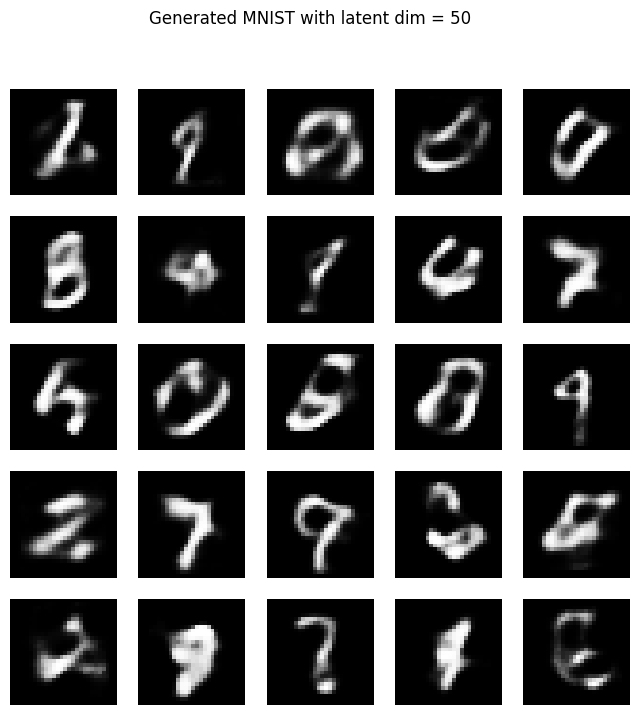

In [44]:
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

def generate_mnist(vae:VAE, file_name:str='generated_img.png'):
  transform = T.ToPILImage()
  col,row = 5,5
  full_size = col*row
  fig = plt.figure(figsize=(8,8))
  fig.suptitle(f"Generated MNIST with latent dim = {vae.latent_dim}")
  for i in range(full_size):
    ax = fig.add_subplot(row,col,i+1)
    tensor_img = sample_from_latent_space(vae)
    img = transform(tensor_img)
    ax.set_axis_off()
    ax.imshow(img,cmap='gray')
  fig.savefig(file_name)
  plt.show()

generate_mnist(vae)


Nous pouvons remarquer que le modèle peut générer des images de chiffres qui sont reconnaissables comme les 7 et les 9. Cependant ceci ne représente qu'une minorité sur les images générées. Certaines ont des formes incohérentes d'autres sont partiellement dessinées.

### Changer la dimension de l'espace latent.

Dans notre premier cas la dimension latente était de 50, nous allons la diminuer à  10 d'une part et augmenter à 100 d'autre part et observer la qualité des résultats générés mais aussi les loss respectives.

In [32]:
vae_10 = VAE(latent_dim=10)
vae_100 =  VAE(latent_dim=100)

for network in [vae_10,vae_100]:
  optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
  train_vae(network,optimizer=optimizer,train_loader=train_loader,n_epochs=15)

  7%|▋         | 1/15 [00:15<03:41, 15.81s/it]

Epoch 0, Loss: 163.99024462890625


 13%|█▎        | 2/15 [00:32<03:34, 16.52s/it]

Epoch 1, Loss: 124.90319412434896


 20%|██        | 3/15 [00:49<03:20, 16.73s/it]

Epoch 2, Loss: 119.4949020670573


 27%|██▋       | 4/15 [01:06<03:03, 16.70s/it]

Epoch 3, Loss: 116.85736967773437


 33%|███▎      | 5/15 [01:22<02:46, 16.62s/it]

Epoch 4, Loss: 115.08961098632813


 40%|████      | 6/15 [01:39<02:30, 16.72s/it]

Epoch 5, Loss: 113.88700577799479


 47%|████▋     | 7/15 [01:57<02:16, 17.00s/it]

Epoch 6, Loss: 113.02248772786459


 53%|█████▎    | 8/15 [02:14<01:58, 16.90s/it]

Epoch 7, Loss: 112.25697335611979


 60%|██████    | 9/15 [02:30<01:40, 16.78s/it]

Epoch 8, Loss: 111.63032991536458


 67%|██████▋   | 10/15 [02:47<01:23, 16.69s/it]

Epoch 9, Loss: 111.08880971679687


 73%|███████▎  | 11/15 [03:04<01:07, 16.85s/it]

Epoch 10, Loss: 110.59393374023438


 80%|████████  | 12/15 [03:21<00:50, 16.90s/it]

Epoch 11, Loss: 110.18068780924479


 87%|████████▋ | 13/15 [03:37<00:33, 16.79s/it]

Epoch 12, Loss: 109.78876954752604


 93%|█████████▎| 14/15 [03:54<00:16, 16.68s/it]

Epoch 13, Loss: 109.40930240885416


100%|██████████| 15/15 [04:10<00:00, 16.73s/it]


Epoch 14, Loss: 109.1219458984375


  7%|▋         | 1/15 [00:17<04:10, 17.89s/it]

Epoch 0, Loss: 174.1514749674479


 13%|█▎        | 2/15 [00:35<03:47, 17.52s/it]

Epoch 1, Loss: 132.52838997395833


 20%|██        | 3/15 [00:52<03:30, 17.58s/it]

Epoch 2, Loss: 120.72132535807292


 27%|██▋       | 4/15 [01:10<03:15, 17.82s/it]

Epoch 3, Loss: 114.88761713867187


 33%|███▎      | 5/15 [01:29<03:01, 18.10s/it]

Epoch 4, Loss: 111.81515701497396


 40%|████      | 6/15 [01:47<02:42, 18.02s/it]

Epoch 5, Loss: 110.02289643554687


 47%|████▋     | 7/15 [02:05<02:24, 18.01s/it]

Epoch 6, Loss: 108.81921840820313


 53%|█████▎    | 8/15 [02:24<02:07, 18.26s/it]

Epoch 7, Loss: 107.922966796875


 60%|██████    | 9/15 [02:42<01:49, 18.17s/it]

Epoch 8, Loss: 107.28397750651041


 67%|██████▋   | 10/15 [03:00<01:30, 18.09s/it]

Epoch 9, Loss: 106.74060416666667


 73%|███████▎  | 11/15 [03:19<01:13, 18.38s/it]

Epoch 10, Loss: 106.32265548502605


 80%|████████  | 12/15 [03:36<00:54, 18.21s/it]

Epoch 11, Loss: 105.98094793294271


 87%|████████▋ | 13/15 [03:54<00:36, 18.08s/it]

Epoch 12, Loss: 105.65031549479167


 93%|█████████▎| 14/15 [04:13<00:18, 18.40s/it]

Epoch 13, Loss: 105.41397119140625


100%|██████████| 15/15 [04:31<00:00, 18.11s/it]

Epoch 14, Loss: 105.18940403645833


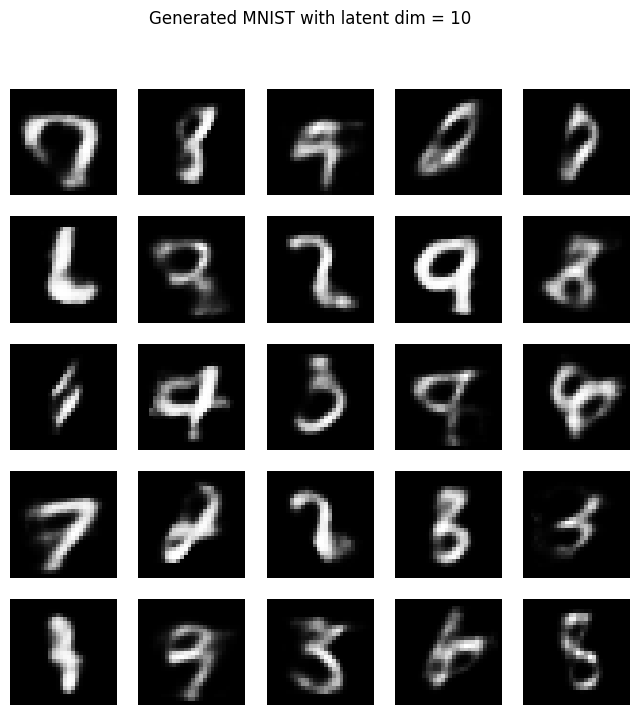

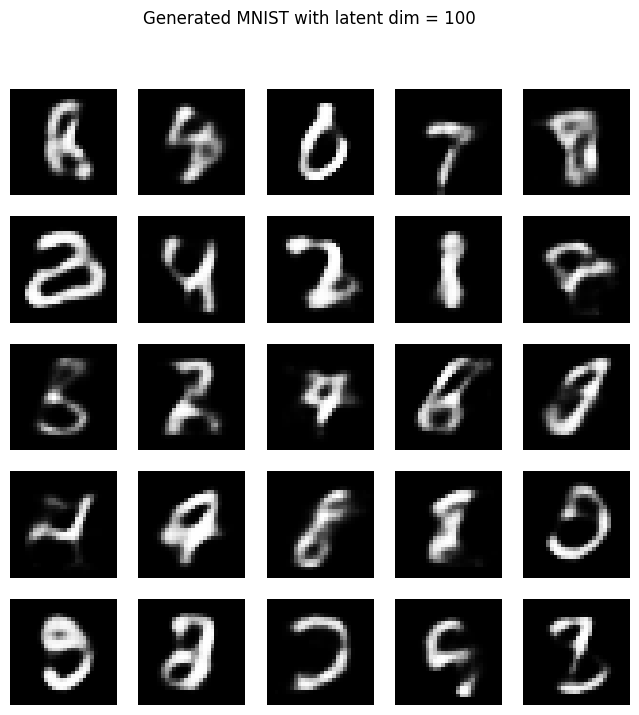

In [47]:
for network,name in zip([vae_10,vae_100],['VAE_10','VAE_100']):
  generate_mnist(network,f'{name}.png')

On remarque encore une fois que les données générées sont en majorité invraisemblables pour un humain. Notons toutefois que les chiffres 9, 7 et 1 sont reconnaissables par comparaison avec les autres.

### Changer L'architecture du VAE

### Paramétrer la fonction loss pour pondérer les deux termes

Nous allons créer une fonction de loss qui puisse apprendre à paramétrer la pondération des deux termes

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return self.alpha * BCE + self.beta * KLD
